In [10]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi, sqrt, log2, exp
from enum import Enum
from typing import Tuple, Dict, List, Optional
import warnings
warnings.filterwarnings('ignore')

class PhotonSource:
    def __init__(self, mu):
        self.mu = mu

    def photon_distribution(self, n_max=20):
        # This distribution remains general for SPDC sources,
        # representing the probability of emitting n photon pairs per pulse.
        n_values = np.arange(n_max + 1)
        p_s = (n_values + 1) * ((self.mu / 2) ** n_values) / ((1 + (self.mu / 2)) ** (n_values + 2))
        return p_s

# ========================== Channel Class ==========================
class ChannelType(Enum):
    FIBER = "fiber"
    FSO = "fso"  # Free Space Optical

class QuantumChannel:
    """
    Quantum channel class supporting both fiber and FSO transmission
    """
    
    def __init__(self, channel_type: ChannelType):
        self.channel_type = channel_type
        self._set_channel_parameters()
    
    def _set_channel_parameters(self):
        """Set channel-specific parameters"""
        if self.channel_type == ChannelType.FIBER:
            # Fiber channel parameters
            self.alpha_db = 0.2          # Atmospheric attenuation (dB/km)
            self.max_distance = 300      # Maximum practical distance (km)
            self.noise_components = {
                'raman': 5e-5,           # Raman scattering noise
                'dark': 5e-6             # Dark count noise
            }
        
        elif self.channel_type == ChannelType.FSO:
            # Free Space Optical parameters
            self.alpha_db = 0.1          # Atmospheric attenuation (dB/km)
            self.max_distance = 50       # Maximum practical distance (km)
            self.beam_divergence = 0.025e-3   # Beam divergence (rad)
            self.tx_aperture = 0.01      # Transmitter aperture diameter (m)
            self.rx_aperture = 0.03      # Receiver aperture diameter (m)
            self.noise_components = {
                'stray': 5e-6,           # Stray light noise
                'dark': 5e-6             # Dark count noise
            }
        
        # Convert dB/km to 1/km for calculations
        self.alpha_linear = self.alpha_db / 4.343
        self.total_noise_prob = sum(self.noise_components.values())
    
    def transmittance(self, distance_km: float) -> float:
        """
        Calculate channel transmittance for given distance
        
        Args:
            distance_km: Distance in kilometers
            
        Returns:
            Transmittance value between 0 and 1
        """
        if self.channel_type == ChannelType.FIBER:
            # Fiber: Only atmospheric/material losses
            return 10 ** (-self.alpha_db * distance_km / 10)
        
        elif self.channel_type == ChannelType.FSO:
            # FSO: Geometric spreading + atmospheric losses
            distance_m = distance_km * 1000
            
            # Geometric loss due to beam divergence
            geo_loss = (self.rx_aperture / (self.tx_aperture + self.beam_divergence * distance_m)) ** 2
            
            # Atmospheric loss
            atm_loss = exp(-self.alpha_linear * distance_km)
            
            return geo_loss * atm_loss
    
    def get_channel_info(self) -> Dict:
        """Return channel configuration information"""
        return {
            'type': self.channel_type.value,
            'alpha_db': self.alpha_db,
            'max_distance': self.max_distance,
            'noise_components': self.noise_components,
            'total_noise': self.total_noise_prob
        }
    
    def update_parameters(self, **kwargs):
        """Update channel parameters dynamically"""
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
                if key == 'alpha_db':
                    self.alpha_linear = value / 4.343
                elif key in ['raman', 'dark', 'stray']:
                    self.noise_components[key] = value
                    self.total_noise_prob = sum(self.noise_components.values())

    def get_misalignment_error(self, distance_km):
        base = 0.015
        factor = 0.0002
        return min(0.1, base + factor * distance_km)

# ========================== Detector Class ==========================
class QuantumDetector:
    """
    Quantum detector system for photon pair detection
    """
    
    def __init__(self, detector_efficiency: float = 0.6, collection_efficiency: float = 0.6):
        self.eta_detector = detector_efficiency       # Individual detector efficiency
        self.eta_collection = collection_efficiency   # Collection efficiency
        self.eta_total = self.eta_detector * self.eta_collection  # Total detection efficiency
        
        # Source parameters
        self.pair_generation_rate = 0.64e6    # pairs per second, will be updated by E91Simulator
        self.afterpulsing_prob = 0.02    # Add to __init__
        self.timing_jitter_error = 0.01   # Fraction of detection error due to jitter

        
    def compute_detection_probabilities(self, transmittance: float) -> Dict[str, float]:
        """
        Compute detection probabilities for different photon number states
        
        Args:
            transmittance: Channel transmittance
            
        Returns:
            Dictionary with probabilities for different detection scenarios
        """
        T = transmittance
        
        # Photon number state probabilities after transmission
        p_both = T ** 2          # Both photons arrive
        p_single = 2 * T * (1 - T)   # One photon arrives
        p_none = (1 - T) ** 2    # No photons arrive
        
        return {
            'p_both_arrive': p_both,
            'p_single_arrive': p_single,
            'p_none_arrive': p_none
        }
    
    def compute_photon_detection_probability(self, photons: int) -> float:
        """
        Computes the probability of detecting at least one photon out of 'photons' arriving,
        adjusted for saturation effects.
        
        Args:
            photons: Number of incoming photons
            
        Returns:
            Adjusted detection probability
        """
        if photons <= 0:
            return 0.0

        # Raw detection probability for at least one photon being detected
        p_detect_signal = 1 - (1 - self.eta_total) ** photons

        # Apply saturation correction
        p_detect_signal *= self.compute_saturation_factor(photons)

        # Apply afterpulsing and timing jitter if needed (optional)
        p_detect_signal *= (1 - self.afterpulsing_prob) * (1 - self.timing_jitter_error)

        return min(1.0, p_detect_signal)

        
    def compute_click_probability(self, noise_prob: float) -> float:
        """
        Compute probability of detector click (including noise)
        
        Args:
            noise_prob: Total noise probability per detector
            
        Returns:
            Click probability
        """
        base_click = self.eta_total + 2 * noise_prob * (1 - self.eta_total)
        afterpulse_penalty = 1 + self.afterpulsing_prob
        return min(1.0, base_click * afterpulse_penalty)
    
    def compute_normalization_factor(self, transmittance: float, noise_prob: float) -> float:
        """
        Compute normalization factor N for correlation calculations,
        using realistic detection probability with saturation.
        
        Args:
            transmittance: Channel transmittance
            noise_prob: Total noise probability
        
        Returns:
            Normalization factor N
        """
        # This method is not directly used in the E91Simulator's main simulation loop
        # where the normalization is computed over the photon distribution.
        # However, it's good to keep it consistent if it were to be used elsewhere.
        
        probs = self.compute_detection_probabilities(transmittance)

        # Estimate 1 photon per detection arm on average
        eta_eff = self.compute_photon_detection_probability(1)

        # Numerator: Both photons detected successfully with realistic efficiency
        numerator = probs['p_both_arrive'] * (eta_eff ** 2)

        # Adjusted total click probability using eta_eff
        click_prob = eta_eff + 2 * noise_prob * (1 - eta_eff)

        # Denominator: All cases of clicks (both signal + noise)
        denominator = (
            probs['p_both_arrive'] * (click_prob ** 2) +
            2 * probs['p_single_arrive'] * noise_prob * click_prob +
            4 * ((1 - transmittance) ** 2) * (noise_prob ** 2) # Changed p_noise to noise_prob
        )

        return numerator / denominator if denominator > 0 else 0
    
    def update_efficiency(self, detector_eff: Optional[float] = None, 
                          collection_eff: Optional[float] = None):
        """Update detector efficiencies"""
        if detector_eff is not None:
            self.eta_detector = detector_eff
        if collection_eff is not None:
            self.eta_collection = collection_eff
        self.eta_total = self.eta_detector * self.eta_collection

    def compute_saturation_factor(self, photons: int) -> float:
        # More realistic saturation curve
        return 1.0 / (1.0 + 0.1 * photons) if photons > 1 else 1.0
    
    def compute_multi_photon_detection_probability(self, photons: int) -> float:
        if photons <= 0:
            return 0.0
        p_detect = 1 - (1 - self.eta_total) ** photons
        p_detect *= self.compute_saturation_factor(photons)
        p_detect *= (1 - self.afterpulsing_prob) * (1 - self.timing_jitter_error)
        return min(1.0, p_detect)


# ========================== E91 Simulator Class ==========================
class E91Simulator:
    """
    Complete E91 quantum key distribution simulator
    Supports center-source configuration with physics realism,
    adapted for Type-0 SPDC source.
    """

    def __init__(self, channel: QuantumChannel, detector: QuantumDetector, 
                 distance_km: float, 
                 f_rep: float = 80e6,
                 nu_s: float = 0.64e6,   # Brightness (pairs/sec/mW)
                 pump_power_mw: float = 1.0, # Pump power in mW
                 mu: Optional[float] = None # Optional: direct mean photon number per pulse
                ):
        self.channel = channel
        self.detector = detector
        self.distance_km = distance_km   # store for reuse
        self.f_rep = f_rep
        self.nu_s = nu_s
        self.pump_power_mw = pump_power_mw
        
        if mu is not None:
            self.mu = mu # Use direct mu if provided (for 'vs mu' plots)
            self.detector.pair_generation_rate = self.mu * self.f_rep
        else:
            # Calculate pair generation rate from brightness and pump power
            self.detector.pair_generation_rate = self.nu_s * self.pump_power_mw
            # Calculate mu (mean photon number per pulse) based on the pair generation rate
            self.mu = self.detector.pair_generation_rate / self.f_rep
        
        self.spdc_source = PhotonSource(mu=self.mu)   # SPDC source with mean photon number mu


        # Bell test measurement settings (CHSH inequality)
        self.measurement_angles = {
            'alice_1': 0,
            'alice_2': pi / 4,
            'bob_1': -pi / 8,
            'bob_2': pi / 8
        }
        self.entanglement_phase = 0 # Adjusted for Type-0 SPDC with ideal correlations

        self.simulation_results = {}

        # Add center-source support:
        half_distance = distance_km / 2

        self.channel_alice = QuantumChannel(channel.channel_type)
        self.channel_bob = QuantumChannel(channel.channel_type)

        # Copy configuration and update distances
        self.channel_alice.update_parameters(**channel.get_channel_info())
        self.channel_bob.update_parameters(**channel.get_channel_info())

    
    @staticmethod
    def binary_entropy(x: float) -> float:
        """
        Calculate binary entropy function H(x) = -x*log₂(x) - (1-x)*log₂(1-x)
        
        Args:
            x: Probability value between 0 and 1
            
        Returns:
            Binary entropy value
        """
        epsilon = 1e-12
        x = np.clip(x, epsilon, 1 - epsilon)
        return -x * log2(x) - (1 - x) * log2(1 - x)
    
    def correlation_function(self, theta_alice: float, theta_bob: float, 
                             normalization: float, phase: float) -> float:
        """
        Calculate correlation function E(θₐ, θᵦ) for given measurement angles
        for a Type-0 SPDC source.
        
        Args:
            theta_alice: Alice's measurement angle
            theta_bob: Bob's measurement angle
            normalization: Normalization factor N
            phase: Entanglement phase (ideally 0 for |HH>+|VV> or pi for |HH>-|VV> etc.,
                   affecting the overall sign or shift of the cosine)
            
        Returns:
            Correlation value
        """
        # For a Type-0 source, the ideal correlation is typically cos(2*(theta_alice - theta_bob + phase_offset))

        ideal_correlation = cos(2 * (theta_alice - theta_bob))
        return normalization * cos(2 * (theta_alice - theta_bob) + phase)
    
    def compute_bell_parameter(self, normalization: float, phase: float) -> float:
        """
        Compute Bell parameter S for CHSH inequality
        
        Args:
            normalization: Normalization factor N
            phase: Entanglement phase
            
        Returns:
            Bell parameter S
        """
        angles = self.measurement_angles
        
        # Calculate four correlation functions
        E11 = self.correlation_function(angles['alice_1'], angles['bob_1'], 
                                        normalization, phase)
        E12 = self.correlation_function(angles['alice_1'], angles['bob_2'], 
                                        normalization, phase)
        E21 = self.correlation_function(angles['alice_2'], angles['bob_1'], 
                                        normalization, phase)
        E22 = self.correlation_function(angles['alice_2'], angles['bob_2'], 
                                        normalization, phase)
        
        # CHSH combination: S = |E₁₁ + E₁₂ - E₂₁ + E₂₂|
        S = abs(E11 + E12 - E21 + E22)
        
        return S
    
    def compute_qber(self, bell_parameter: float) -> float:
        """
        Compute Quantum Bit Error Rate (QBER) from Bell parameter
        
        Args:
            bell_parameter: Bell parameter S
            
        Returns:
            QBER value
        """
        # Clip S to valid range [0, 2√2]
        S = np.clip(bell_parameter, 0, 2 * sqrt(2))
        return 0.5 * (1 - S / (2 * sqrt(2)))
    
    def compute_secret_key_rate(self, bell_parameter: float, qber: float, 
                                 transmittance: float) -> float:
        """
        Compute Secret Key Rate using Acín et al.'s formula
        
        Args:
            bell_parameter: Bell parameter S
            qber: Quantum bit error rate
            transmittance: Channel transmittance
            
        Returns:
            Secret key rate in bits per second
        """
        S = bell_parameter
        
        # No key extraction possible if S ≤ 2 (no Bell violation)
        if S <= 2:
            return 0
        
        # Acín et al. formula term
        term = (1 + sqrt(S**2 / 4 - 1)) / 2
        
        # SKR = (1/3) * ν * T * [1 - H(Q) - H(term)]
        skr = (1/3) * self.detector.pair_generation_rate * transmittance * \
              (1 - self.binary_entropy(qber) - self.binary_entropy(term))
        
        return max(0, skr)   # Ensure non-negative
    
    def simulate_single_distance(self, distance_km: float, p_eve: float = 0.0) -> Dict:
        """
        Simulate E91 protocol for a single distance with optional eavesdropping.

        Args:
            distance_km: Distance in kilometers
            p_eve: Eavesdropping probability (0 = no Eve, 1 = full decoherence)
        
        Returns:
            Dictionary of simulation results
        """
        # Channel transmittance for center-source setup
        T_A = self.channel_alice.transmittance(distance_km / 2)
        T_B = self.channel_bob.transmittance(distance_km / 2)
        T = T_A * T_B

        # SPDC photon number distribution (mean μ already set in self.spdc_source)
        # This distribution applies to both Type-0 and Type-II SPDC sources.
        distribution = self.spdc_source.photon_distribution(n_max=10)

        numerator_sum = 0
        denominator_sum = 0

        # Noise probability for a single detector.
        p_noise = self.channel.total_noise_prob
        
        for n, p_n in enumerate(distribution):
            if n == 0:
                continue # No photons, no signal.

            p_signal = self.detector.compute_multi_photon_detection_probability(n)
            
            # The total click probability for one detector (signal OR noise)
            # This assumes a detector can click due to signal or noise, but not both simultaneously in a way that compounds.
            total_click_prob_per_detector = p_signal + p_noise * (1 - p_signal)

            eta_total_detector = self.detector.eta_total # Total efficiency of *one* detector
            
            p_det_signal_one_side = eta_total_detector * T # Efficiency * transmittance for one photon on one side
            p_signal_det_eff = self.detector.compute_multi_photon_detection_probability(n)

            # = p_signal_det_eff + p_noise * (1 - p_signal_det_eff)
            total_click_prob_per_detector = p_signal_det_eff + p_noise * (1 - p_signal_det_eff)

            p_signal_alice = T_A * self.detector.eta_total
            p_signal_bob = T_B * self.detector.eta_total

            p_n_one_pair = self.spdc_source.photon_distribution(n_max=1)[1] if len(self.spdc_source.photon_distribution(n_max=1)) > 1 else 0

            p_det_alice = T_A * self.detector.eta_total
            p_det_bob = T_B * self.detector.eta_total
            prob_true_coincidence = p_n_one_pair * p_det_alice * p_det_bob

            numerator_sum = 0 # Represents sum of true entangled coincidence probabilities
            denominator_sum = 0 # Represents sum of all coincidence probabilities (signal + noise + multi-pair)

            for n, p_n in enumerate(distribution): # n is the number of pairs emitted
                p_signal_det_eff_at_A = self.detector.compute_multi_photon_detection_probability(n)
                p_signal_det_eff_at_B = self.detector.compute_multi_photon_detection_probability(n)
                total_click_prob_A = p_signal_det_eff_at_A + p_noise * (1 - p_signal_det_eff_at_A)
                total_click_prob_B = p_signal_det_eff_at_B + p_noise * (1 - p_signal_det_eff_at_B)

                
                if n == 1:
                    single_photon_det_eff_A = self.detector.compute_multi_photon_detection_probability(1)
                    single_photon_det_eff_B = self.detector.compute_multi_photon_detection_probability(1)

                    numerator_sum += p_n * T_A * single_photon_det_eff_A * T_B * single_photon_det_eff_B
                

            accidental_prob = 1 - exp(-self.mu) # This tries to model multi-pair contamination.

            numerator_sum = 0
            denominator_sum = 0

            for n, p_n in enumerate(distribution):
                if n == 0:
                    continue

                p_signal = self.detector.compute_multi_photon_detection_probability(n)
                p_noise = self.channel.total_noise_prob

                # Total click probability for one detector (signal + noise)
                total_click_prob = p_signal + p_noise * (1 - p_signal)
                
                numerator_sum += p_n * (T ** 2) * (p_signal ** 2) * (1 - accidental_prob)
                denominator_sum += p_n * (
                    (T ** 2) * (total_click_prob ** 2) +
                    2 * T * (1 - T) * p_noise * total_click_prob +
                    4 * ((1 - T) ** 2) * (p_noise ** 2) # This term is for when no signal photon arrives (1-T)**2
                )
            
            N_raw = numerator_sum / denominator_sum if denominator_sum > 0 else 0
            N = (1 - p_eve) * N_raw   # Apply decoherence from Eve
            # --- End of Modified simulate_single_distance ---

        # Bell parameter, QBER, SKR
        S = self.compute_bell_parameter(N, self.entanglement_phase) # Phase for Type-0 is usually 0 or pi
        Q = self.compute_qber(S)
        Q += self.detector.timing_jitter_error
        Q += self.channel.get_misalignment_error(distance_km)
        Q = min(0.5, Q)

        SKR = self.compute_secret_key_rate(S, Q, T)

        return {
            'distance': distance_km,
            'transmittance': T,
            'normalization': N,
            'bell_parameter': S,
            'qber': Q,
            'qber_percent': Q * 100,
            'secret_key_rate': SKR,
            'bell_violation': S > 2,
            'secure_communication': S > 2 and Q < 0.146
        }
        
    def simulate_distance_range(self, min_distance: float = 0.01, 
                                 max_distance: Optional[float] = None,
                                 num_points: int = 300) -> Dict:
        """
        Simulate E91 protocol over a range of distances
        
        Args:
            min_distance: Minimum distance in km
            max_distance: Maximum distance in km (uses channel max if None)
            num_points: Number of distance points to simulate
            
        Returns:
            Dictionary with arrays of simulation results
        """
        if max_distance is None:
            max_distance = self.channel.max_distance
        
        distances = np.linspace(min_distance, max_distance, num_points)
        
        results = {
            'distances': distances,
            'transmittances': [],
            'bell_parameters': [],
            'qbers': [],
            'qber_percents': [],
            'secret_key_rates': [],
            'bell_violations': [],
            'secure_regions': []
        }
        
        for distance in distances:
            single_result = self.simulate_single_distance(distance)
            
            results['transmittances'].append(single_result['transmittance'])
            results['bell_parameters'].append(single_result['bell_parameter'])
            results['qbers'].append(single_result['qber'])
            results['qber_percents'].append(single_result['qber_percent'])
            results['secret_key_rates'].append(single_result['secret_key_rate'])
            results['bell_violations'].append(single_result['bell_violation'])
            results['secure_regions'].append(single_result['secure_communication'])
        
        # Convert lists to numpy arrays for easier manipulation
        for key in results:
            if key != 'distances':
                results[key] = np.array(results[key])
        
        # Store results for later use
        self.simulation_results = results
        
        return results
    
    def update_measurement_angles(self, **angles):
        """
        Update measurement angles for Bell test
        
        Args:
            **angles: Keyword arguments for angle updates
                      (alice_1, alice_2, bob_1, bob_2)
        """
        for key, value in angles.items():
            if key in self.measurement_angles:
                self.measurement_angles[key] = value
    
    def get_simulation_summary(self) -> Dict:
        """Get summary of current simulation setup"""
        return {
            'channel_info': self.channel.get_channel_info(),
            'detector_efficiency': self.detector.eta_total,
            'measurement_angles': self.measurement_angles,
            'entanglement_phase': self.entanglement_phase
        }

# ========================== Example Usage ==========================
print("E91 QKD Simulator Classes Initialized Successfully!")
print("\nAvailable Classes:")
print("- QuantumChannel: Models fiber and FSO channels")
print("- QuantumDetector: Simulates photon detection systems") 
print("- E91Simulator: Complete E91 protocol simulation (Adapted for Type-0 SPDC)")
print("\nExample instantiation:")
print("channel = QuantumChannel(ChannelType.FIBER)")
print("detector = QuantumDetector()")
print("simulator = E91Simulator(channel, detector)")

# ========================== Plotting Functions ==========================
def plot_qber_vs_distance(distance_range=(1, 300), num_points=50,
                          detector_efficiency=0.6, collection_efficiency=0.6,
                          channel_type="fiber", 
                          receiver_diameter=0.1, transmitter_diameter=0.01,
                          beam_divergence=1e-6, atmospheric_attenuation=0.1,
                          nu_s=0.64e6, pump_power_mw=1.0, f_rep=80e6): 

    distances = np.linspace(*distance_range, num_points)
    qbers = []

    for d in distances:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation * 4.343
            )

        detector = QuantumDetector(detector_efficiency, collection_efficiency)

        # Pass nu_s and pump_power_mw to the E91Simulator
        sim = E91Simulator(channel, detector, distance_km=d, nu_s=nu_s, pump_power_mw=pump_power_mw, f_rep=f_rep) 
        result = sim.simulate_single_distance(d)
        qbers.append(result['qber_percent'])

    plt.figure(figsize=(10, 6))
    plt.plot(distances, qbers, 'bo-', linewidth=2, markersize=6, label='QBER')
    plt.axhline(5, color='magenta', linestyle='--', label='5% Threshold')
    plt.axhline(11, color='red', linestyle='--', label='11% Threshold')
    plt.grid(True)
    plt.xlabel('Distance (km)', fontsize=18)
    plt.ylabel('QBER (%)', fontsize=18)
    plt.title(f'QBER vs Distance ({channel_type.upper()}) - Type-0 SPDC', fontsize=20)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_skr_vs_distance(distance_range=(1, 300), num_points=50,
                          detector_efficiency=0.6, collection_efficiency=0.6,
                          channel_type="fiber", 
                          receiver_diameter=0.1, transmitter_diameter=0.01,
                          beam_divergence=1e-6, atmospheric_attenuation=0.1,
                          nu_s=0.64e6, pump_power_mw=1.0, f_rep=80e6):
    """
    Plot Secret Key Rate (SKR) vs distance for E91 protocol.
    """
    distances = np.linspace(*distance_range, num_points)
    skr_values = []

    for d in distances:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation * 4.343
            )

        detector = QuantumDetector(detector_efficiency, collection_efficiency)
        
        sim = E91Simulator(channel, detector, distance_km=d, nu_s=nu_s, pump_power_mw=pump_power_mw, f_rep=f_rep)
        result = sim.simulate_single_distance(d)
        skr_values.append(result['secret_key_rate'])

    plt.figure(figsize=(10, 6))
    plt.plot(distances, skr_values, 'go-', linewidth=2, markersize=6, label='SKR')
    plt.grid(True)
    plt.xlabel('Distance (km)', fontsize=18)
    plt.ylabel('Secret Key Rate (bps)', fontsize=18)
    plt.title(f'Secret Key Rate vs Distance ({channel_type.upper()}) - Type-0 SPDC', fontsize=20)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_bell_violation_vs_distance(distance_range=(1, 300), num_points=50,
                                     detector_efficiency=0.6, collection_efficiency=0.6,
                                     channel_type="fiber", 
                                     receiver_diameter=0.1, transmitter_diameter=0.01,
                                     beam_divergence=1e-6, atmospheric_attenuation=0.1,
                                     nu_s=0.64e6, pump_power_mw=1.0, f_rep=80e6):
    """
    Plot Bell parameter S vs distance for E91 protocol.
    """
    distances = np.linspace(*distance_range, num_points)
    S_values = []

    for d in distances:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation * 4.343
            )

        detector = QuantumDetector(detector_efficiency, collection_efficiency)

        sim = E91Simulator(channel, detector, distance_km=d, nu_s=nu_s, pump_power_mw=pump_power_mw, f_rep=f_rep)
        result = sim.simulate_single_distance(d)
        S_values.append(result['bell_parameter'])

    plt.figure(figsize=(10, 6))
    plt.plot(distances, S_values, 'ro-', linewidth=2, markersize=6, label='S')
    plt.axhline(2, color='gray', linestyle='--', linewidth=2, label='Classical Limit (S=2)')
    plt.grid(True)
    plt.xlabel('Distance (km)', fontsize=18)
    plt.ylabel('Bell Parameter S', fontsize=18)
    plt.title(f'Bell Violation S vs Distance ({channel_type.upper()}) - Type-0 SPDC', fontsize=20)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_qber_vs_mu(mu_range=(0.01, 1.0), num_points=50,
                    fixed_distance_km=20,
                    f_rep=80e6,
                    detector_efficiency=0.6, collection_efficiency=0.6,
                    channel_type="fiber",
                    nu_s=0.64e6, pump_power_mw=1.0): 
    """
    Plot QBER vs mean photon number μ for E91 protocol.
    """
    mu_values = np.linspace(*mu_range, num_points)
    qber_values = []

    for mu_val in mu_values:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        detector = QuantumDetector(detector_efficiency, collection_efficiency)

        simulator = E91Simulator(channel, detector, distance_km=fixed_distance_km, mu=mu_val, f_rep=f_rep, nu_s=nu_s, pump_power_mw=pump_power_mw)
        result = simulator.simulate_single_distance(fixed_distance_km)

        qber_values.append(result['qber_percent'])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(mu_values, qber_values, 'bo-', linewidth=2, markersize=5)
    plt.axhline(14.6, color='red', linestyle='--', label='QBER Threshold (14.6%)')
    plt.grid(True)
    plt.xlabel('Mean Photon Number μ', fontsize=16)
    plt.ylabel('QBER (%)', fontsize=16)
    plt.title(f'QBER vs μ at {fixed_distance_km} km ({channel_type.upper()}) - Type-0 SPDC', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.show()

E91 QKD Simulator Classes Initialized Successfully!

Available Classes:
- QuantumChannel: Models fiber and FSO channels
- QuantumDetector: Simulates photon detection systems
- E91Simulator: Complete E91 protocol simulation (Adapted for Type-0 SPDC)

Example instantiation:
channel = QuantumChannel(ChannelType.FIBER)
detector = QuantumDetector()
simulator = E91Simulator(channel, detector)


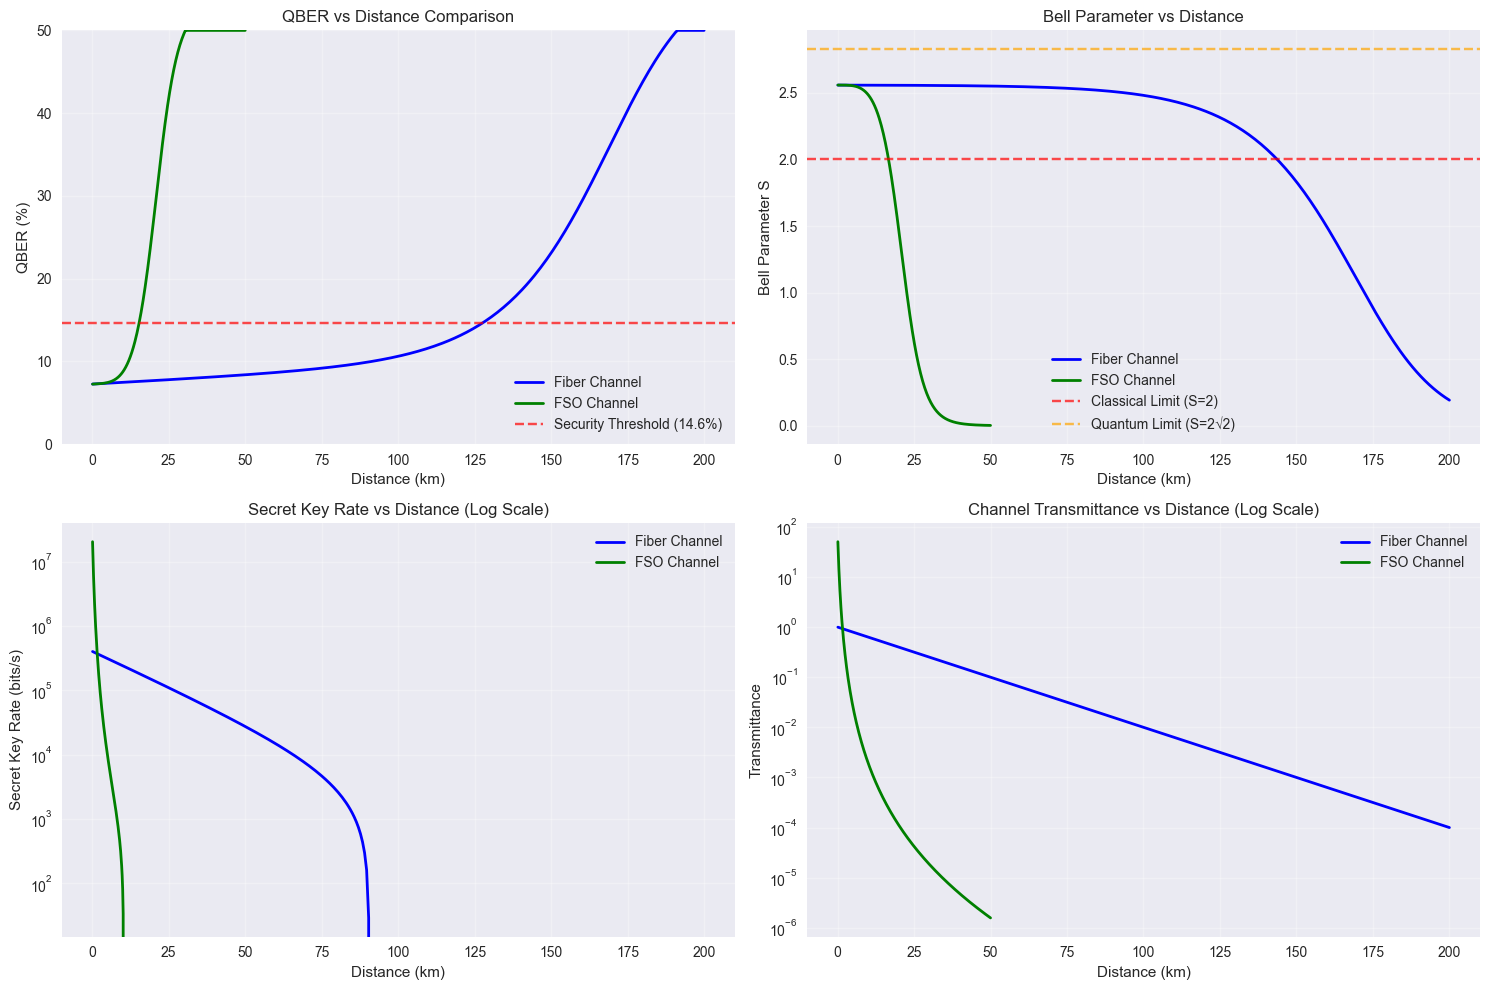

=== E91 QKD Simulation Results ===

Fiber Channel:
  Max distance simulated: 200.0 km
  QBER at max distance: 50.00%
  Bell parameter at max distance: 0.192

FSO Channel:
  Max distance simulated: 50.0 km
  QBER at max distance: 50.00%
  Bell parameter at max distance: 0.002

Fiber secure range: up to 127.1 km
FSO secure range: up to 15.3 km


In [11]:
# ========================== Plotting QBER vs Distance ==========================
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi, sqrt, log2, exp
from enum import Enum
from typing import Tuple, Dict, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style for better plots
plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')

# Assuming the classes from your original code are imported/defined above this point
# [Your E91 simulator classes would be here]

# Initialize channels and detector
fiber_channel = QuantumChannel(ChannelType.FIBER)
fso_channel = QuantumChannel(ChannelType.FSO)
detector = QuantumDetector()

# Initialize simulators (removed the invalid distance_km parameter)
mu = 0.1           # Mean photon number per pulse (adjustable)
f_rep = 80e6       # Pulse repetition rate in Hz

fiber_simulator = E91Simulator(fiber_channel, detector, distance_km=200, mu=mu, f_rep=f_rep)
fso_simulator = E91Simulator(fso_channel, detector, distance_km=50, mu=mu, f_rep=f_rep)

# Run simulations with custom distance ranges
# Fiber can go longer distances, FSO is limited
fiber_results = fiber_simulator.simulate_distance_range(min_distance=0.1, max_distance=200, num_points=300)
fso_results = fso_simulator.simulate_distance_range(min_distance=0.1, max_distance=50, num_points=300)

# Create comprehensive plotting
plt.figure(figsize=(15, 10))

# Plot 1: QBER vs Distance
plt.subplot(2, 2, 1)
plt.plot(fiber_results['distances'], fiber_results['qber_percents'], 
         label='Fiber Channel', color='blue', linewidth=2)
plt.plot(fso_results['distances'], fso_results['qber_percents'], 
         label='FSO Channel', color='green', linewidth=2)
plt.axhline(y=14.6, color='red', linestyle='--', alpha=0.7, label='Security Threshold (14.6%)')
plt.xlabel('Distance (km)')
plt.ylabel('QBER (%)')
plt.title('QBER vs Distance Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 50)  # Cap at 50% (theoretical maximum)

# Plot 2: Bell Parameter vs Distance
plt.subplot(2, 2, 2)
plt.plot(fiber_results['distances'], fiber_results['bell_parameters'], 
         label='Fiber Channel', color='blue', linewidth=2)
plt.plot(fso_results['distances'], fso_results['bell_parameters'], 
         label='FSO Channel', color='green', linewidth=2)
plt.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Classical Limit (S=2)')
plt.axhline(y=2*sqrt(2), color='orange', linestyle='--', alpha=0.7, label='Quantum Limit (S=2√2)')
plt.xlabel('Distance (km)')
plt.ylabel('Bell Parameter S')
plt.title('Bell Parameter vs Distance')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Secret Key Rate vs Distance
plt.subplot(2, 2, 3)
plt.semilogy(fiber_results['distances'], fiber_results['secret_key_rates'], 
             label='Fiber Channel', color='blue', linewidth=2)
plt.semilogy(fso_results['distances'], fso_results['secret_key_rates'], 
             label='FSO Channel', color='green', linewidth=2)
plt.xlabel('Distance (km)')
plt.ylabel('Secret Key Rate (bits/s)')
plt.title('Secret Key Rate vs Distance (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Channel Transmittance vs Distance
plt.subplot(2, 2, 4)
plt.semilogy(fiber_results['distances'], fiber_results['transmittances'], 
             label='Fiber Channel', color='blue', linewidth=2)
plt.semilogy(fso_results['distances'], fso_results['transmittances'], 
             label='FSO Channel', color='green', linewidth=2)
plt.xlabel('Distance (km)')
plt.ylabel('Transmittance')
plt.title('Channel Transmittance vs Distance (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some key results
print("=== E91 QKD Simulation Results ===")
print(f"\nFiber Channel:")
print(f"  Max distance simulated: {fiber_results['distances'][-1]:.1f} km")
print(f"  QBER at max distance: {fiber_results['qber_percents'][-1]:.2f}%")
print(f"  Bell parameter at max distance: {fiber_results['bell_parameters'][-1]:.3f}")

print(f"\nFSO Channel:")
print(f"  Max distance simulated: {fso_results['distances'][-1]:.1f} km")
print(f"  QBER at max distance: {fso_results['qber_percents'][-1]:.2f}%")
print(f"  Bell parameter at max distance: {fso_results['bell_parameters'][-1]:.3f}")

# Find maximum secure distances
fiber_secure_distances = fiber_results['distances'][fiber_results['secure_regions']]
fso_secure_distances = fso_results['distances'][fso_results['secure_regions']]

if len(fiber_secure_distances) > 0:
    print(f"\nFiber secure range: up to {fiber_secure_distances[-1]:.1f} km")
else:
    print("\nFiber: No secure communication possible")

if len(fso_secure_distances) > 0:
    print(f"FSO secure range: up to {fso_secure_distances[-1]:.1f} km")
else:
    print("FSO: No secure communication possible")